In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os
import dask
import dask.bag, dask.diagnostics

pd.options.mode.chained_assignment = None

Identifying Class Imbalance

In [120]:
annotation = pd.read_csv('annotation_df.csv')
img_width = 2448
img_height = 2048

In [121]:
annotation['width'] = annotation['rw']*img_width
annotation['height'] = annotation['rh']*img_height
annotation['aspect_ratio'] = annotation['width'] / annotation['height']

In [122]:
print(annotation.head())

                       image_id  \
0  23945062_20211025_153457_025   
1  23945062_20211025_154748_026   
2  23945062_20211025_155302_653   
3  23945062_20211025_155327_026   
4  23945062_20211025_155646_655   

                                          image_path        cx        cy  \
0  D:/lab/dataset/HelloAppleWorld/Yolo-type/Image...  0.555266  0.541401   
1  D:/lab/dataset/HelloAppleWorld/Yolo-type/Image...  0.409109  0.565186   
2  D:/lab/dataset/HelloAppleWorld/Yolo-type/Image...  0.595792  0.500000   
3  D:/lab/dataset/HelloAppleWorld/Yolo-type/Image...  0.341708  0.611328   
4  D:/lab/dataset/HelloAppleWorld/Yolo-type/Image...  0.477737  0.557617   

         rw        rh  label        width       height  aspect_ratio  
0  0.575253  0.711738      0  1408.219344  1457.639424      0.966096  
1  0.534722  0.667480      5  1309.000000  1367.000000      0.957571  
2  0.029003  0.040039      1    71.000000    82.000000      0.865854  
3  0.039624  0.089844      1    97.000000   184.

In [123]:
annotation['label'].value_counts()

3    1003
1     694
5     255
4     125
0      31
2       5
Name: label, dtype: int64

In [124]:
annotation['label'].value_counts(normalize = True)

3    0.474681
1    0.328443
5    0.120681
4    0.059158
0    0.014671
2    0.002366
Name: label, dtype: float64

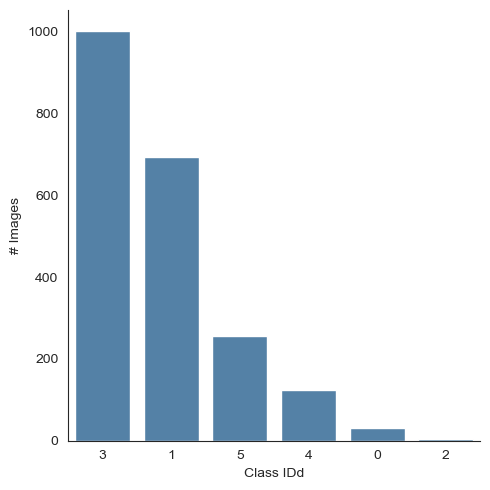

In [170]:
with sns.axes_style('white'):
    g = sns.catplot(x='label', data=annotation, aspect=1,
                    kind='count', color='steelblue', orient='v',
                    order=annotation['label'].value_counts().index)
    g.set_titles('Number of Images by Class')
    g.set_ylabels('# Images')
    g.set_xlabels('Class IDd')
    g.set_xticklabels(step=1)
    plt.show()

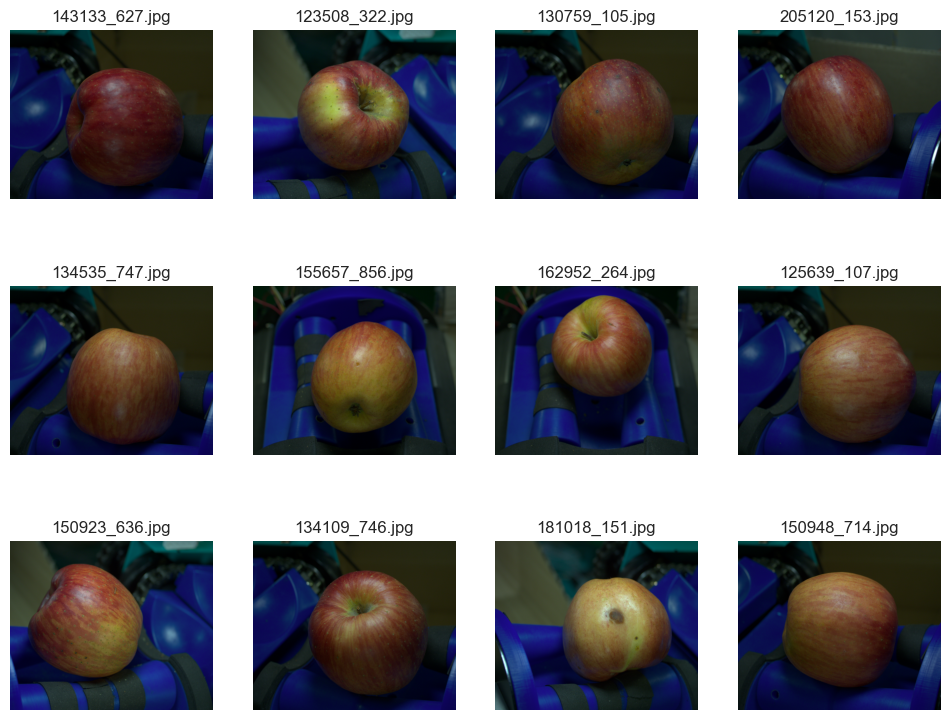

In [169]:
image_paths = annotation['image_path'].drop_duplicates().values.tolist()

num_rows = 3
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 9))
sampled_images = random.sample(image_paths, num_rows * num_cols)

for i in range(num_rows):
    for j in range(num_cols):
        img = cv2.imread(sampled_images[i * num_cols + j])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_name = os.path.basename(sampled_images[i * num_cols + j])[-14:]

        axs[i, j].imshow(img)
        axs[i, j].set_title(image_name)
        axs[i, j].axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()


In [127]:
def get_dims(file):
    """Return dimensions for an RGB image"""
    img = cv2.imread(file)
    height, width, channel = img.shape
    return height, width

[########################################] | 100% Completed | 3.79 ss
[########################################] | 100% Completed | 23.55 s
[########################################] | 100% Completed | 1.55 ss
[########################################] | 100% Completed | 27.20 s
[########################################] | 100% Completed | 4.55 ss
[########################################] | 100% Completed | 12.17 s


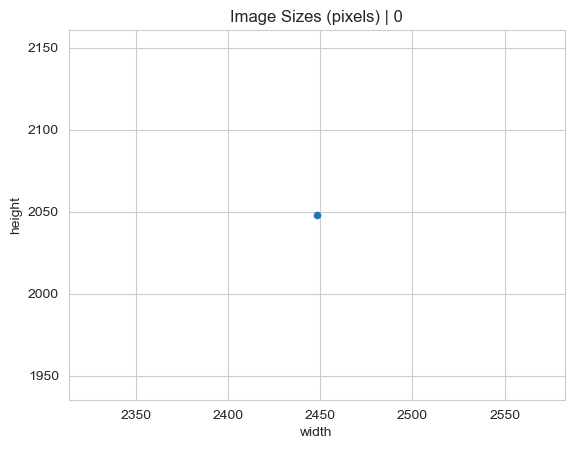

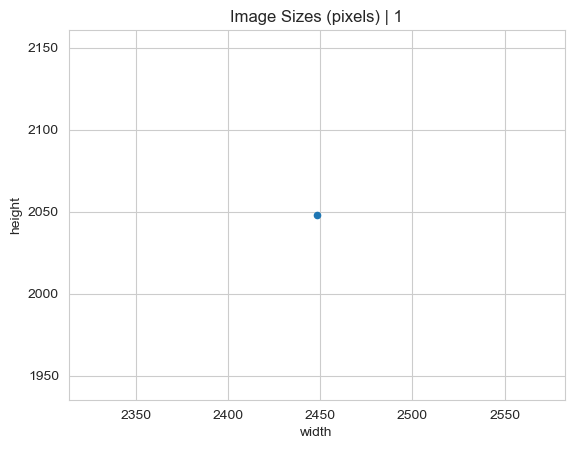

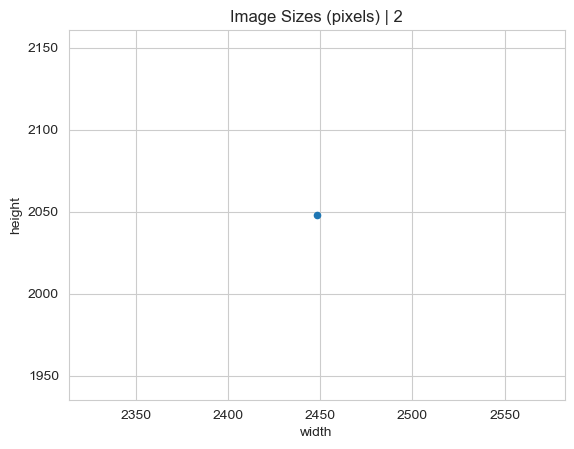

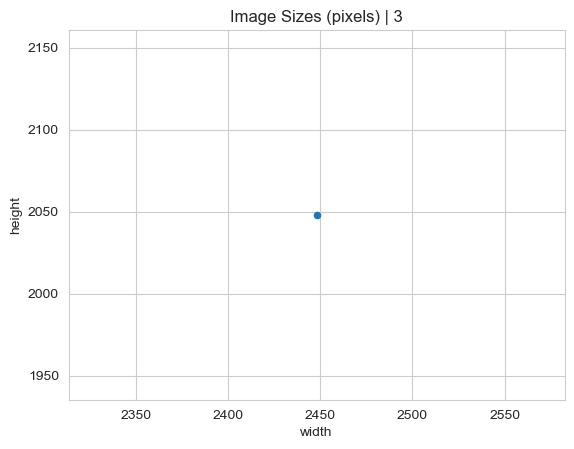

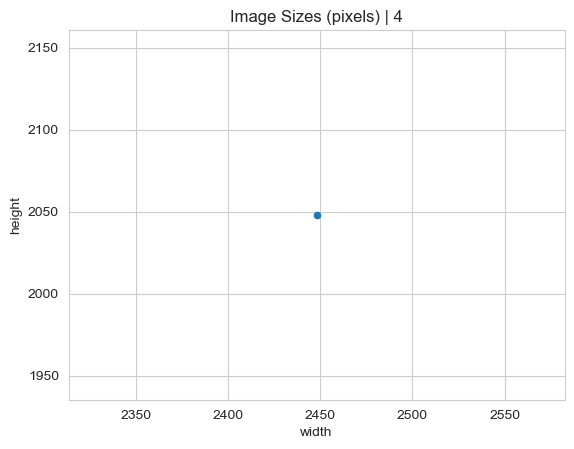

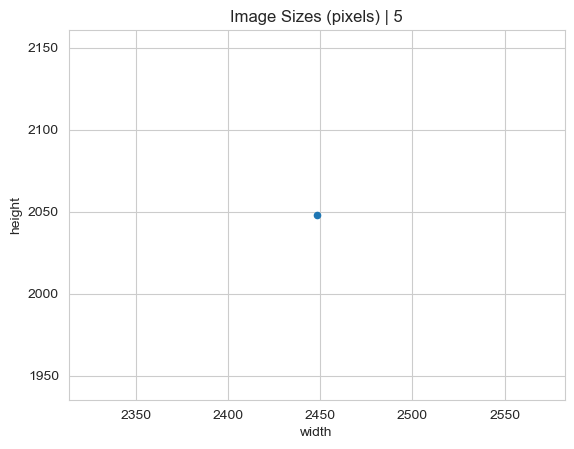

In [171]:
groups = annotation.groupby('label')

for label, group in groups:
    filelist = group['image_path'].values.tolist()
    dims = dask.bag.from_sequence(filelist).map(get_dims)

    with dask.diagnostics.ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(label))
plt.show()

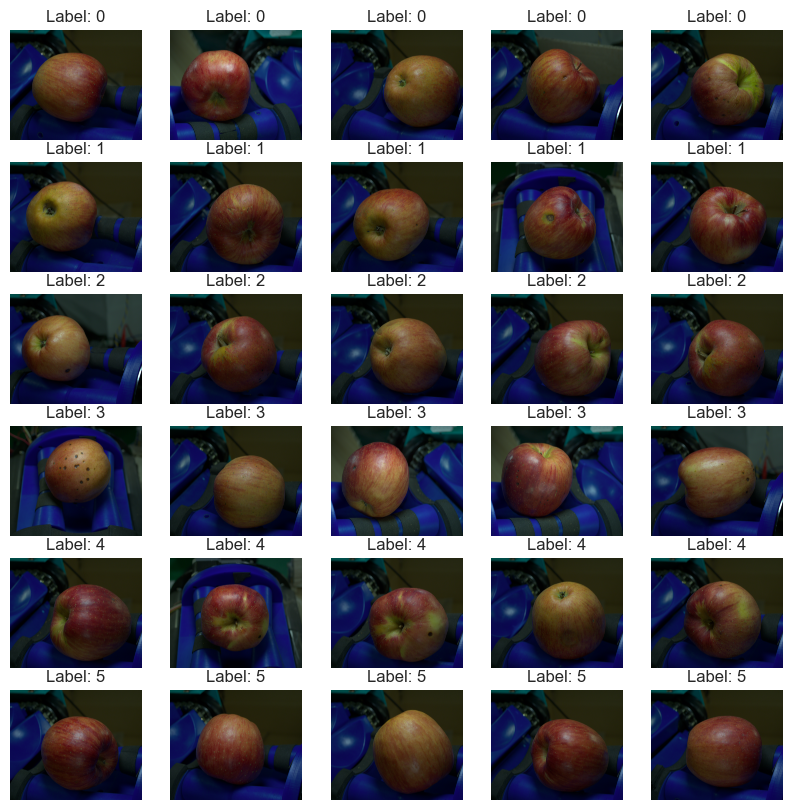

In [172]:
num_samples = 5
fig, axes = plt.subplots(len(groups), num_samples, figsize=(10, 10))

for i, (label, group) in enumerate(groups):
    samples = group.sample(num_samples)
    for j in range(num_samples):
        image_path = samples['image_path'].values[j]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axes[i, j].imshow(image)
        axes[i, j].set_title('Label: {}'.format(label))
        axes[i, j].axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

In [162]:
pd.options.mode.chained_assignment = None
group_0 = groups.get_group(0)
# Define the bins for aspect ratios
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

# Bin the aspect ratios into the defined bins
group_0['aspect_ratio_bins'] = pd.cut(group_0['aspect_ratio'], bins=bins)

# Count the number of annotations in each bin
counts = group_0['aspect_ratio_bins'].value_counts(ascending=False)

In [163]:
counts

(0.5, 1.0]    15
(1.0, 1.5]     8
(0.0, 0.5]     4
(1.5, 2.0]     2
(2.5, 3.0]     1
(3.5, 4.0]     1
(2.0, 2.5]     0
(3.0, 3.5]     0
Name: aspect_ratio_bins, dtype: int64

In [167]:
# Define the bins for aspect ratios
bins_dict = {0 : [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
        1 : [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6],
        2 : [0, 0.2, 0.4, 0.6, 0.8, 1],
        3 : [0, 0.5, 1, 1.5, 2, 2.5, 3],
        4 : [0, 1, 2, 3, 4, 5, 6, 7, 8],
        5 : [0.6, 0.8, 1, 1.2]}
for label, group in groups:
    bins = bins_dict[label]
    group['aspect_ratio_bins'] = pd.cut(group['aspect_ratio'], bins=bins)
    counts = group['aspect_ratio_bins'].value_counts(ascending=False)
    print(f'Annotation Distribution | Class {label}')
    display(counts)
    print('-'*50)

Annotation Distribution | Class 0


(0.5, 1.0]    15
(1.0, 1.5]     8
(0.0, 0.5]     4
(1.5, 2.0]     2
(2.5, 3.0]     1
(3.5, 4.0]     1
(2.0, 2.5]     0
(3.0, 3.5]     0
Name: aspect_ratio_bins, dtype: int64

--------------------------------------------------
Annotation Distribution | Class 1


(0.5, 1.0]    312
(1.0, 1.5]    238
(1.5, 2.0]     58
(0.0, 0.5]     30
(2.0, 2.5]     24
(2.5, 3.0]     17
(3.0, 3.5]      7
(3.5, 4.0]      5
(4.0, 4.5]      1
(4.5, 5.0]      1
(5.0, 5.5]      0
(5.5, 6.0]      0
Name: aspect_ratio_bins, dtype: int64

--------------------------------------------------
Annotation Distribution | Class 2


(0.8, 1.0]    3
(0.4, 0.6]    2
(0.0, 0.2]    0
(0.2, 0.4]    0
(0.6, 0.8]    0
Name: aspect_ratio_bins, dtype: int64

--------------------------------------------------
Annotation Distribution | Class 3


(1.0, 1.5]    520
(0.5, 1.0]    465
(1.5, 2.0]     15
(2.5, 3.0]      2
(2.0, 2.5]      1
(0.0, 0.5]      0
Name: aspect_ratio_bins, dtype: int64

--------------------------------------------------
Annotation Distribution | Class 4


(0, 1]    71
(1, 2]    41
(2, 3]     9
(4, 5]     3
(7, 8]     1
(3, 4]     0
(5, 6]     0
(6, 7]     0
Name: aspect_ratio_bins, dtype: int64

--------------------------------------------------
Annotation Distribution | Class 5


(1.0, 1.2]    133
(0.8, 1.0]    122
(0.6, 0.8]      0
Name: aspect_ratio_bins, dtype: int64

--------------------------------------------------


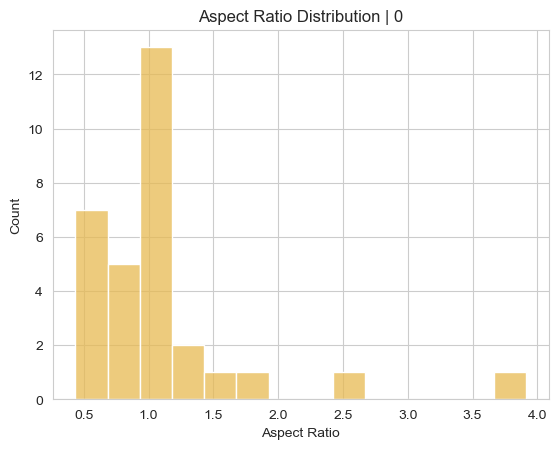

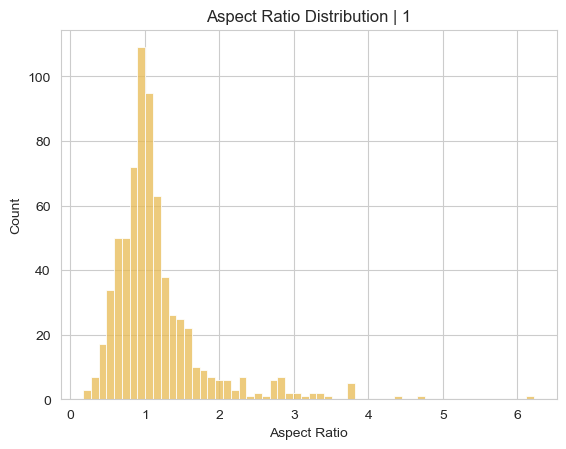

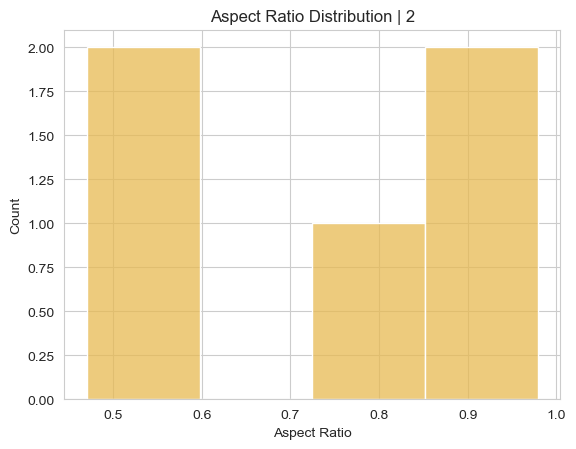

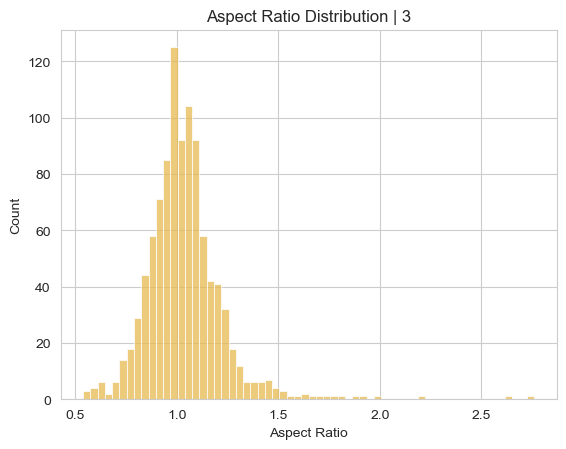

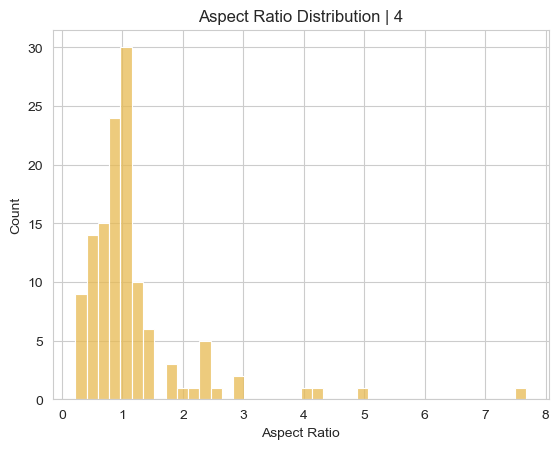

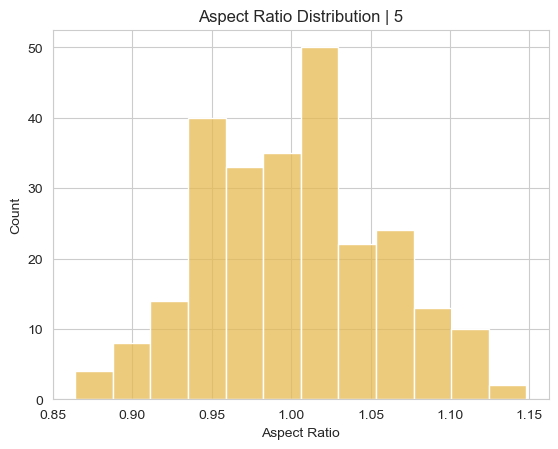

In [136]:
for label, group in groups:
    plot = sns.histplot(data=group,
                        x="aspect_ratio",
                        color='#e7ba52')
    plot.set(xlabel='Aspect Ratio',
             title=f'Aspect Ratio Distribution | {label}')
    plt.show()